# Spotify Songs Recommender System


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
songs=pd.read_csv('music.csv')

In [3]:
songs

,title,genres,year
0,I Didn't Mean To,Jazz,1997
1,Soul Deep,Jazz|Hate|Rock,1969
2,Amor De Cabaret,Folk|Romance,1997
3,Something Girls,Folk|Classic|Romance,1982
4,Face the Ashes,Folk,2007
...,...,...,...
9638,Playing James Mason,Love|Art|Folk|Rock,1997
9639,Mon dieu,Art|Folk|Rock,1997
9640,Virtuous Woman,Classic,2002
9641,Sag es sag es feat Neo,Love|Art,2006


In [4]:
songs.shape

(9643, 3)

In [6]:
songs.isnull().sum()

title     0
genres    0
year      0
dtype: int64

In [7]:
def create_missing_df(dataframe):
    missing_index=dataframe.columns.tolist()
    missing=dataframe.isnull().sum().tolist()
    missing_df=pd.DataFrame({'Missing':missing}, index=missing_index)
    return missing_df

In [8]:
create_missing_df(songs)

,Missing
title,0
genres,0
year,0


# Explore Generers

In [10]:
r,c = songs[songs['genres']=='(no genres listed)'].shape
print('The number of songs that do not have info about genre:',r)

The number of songs that do not have info about genre: 0


In [11]:
songs=songs[~(songs['genres']=='(no genres listed)')].reset_index(drop=True)

In [12]:
songs[['title','genres']].head(5)

,title,genres
0,I Didn't Mean To,Jazz
1,Soul Deep,Jazz|Hate|Rock
2,Amor De Cabaret,Folk|Romance
3,Something Girls,Folk|Classic|Romance
4,Face the Ashes,Folk


In [13]:
songs['genres']=songs['genres'].str.replace('|', ' ')

<ipython-input-13-434744e1d09d>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  songs['genres']=songs['genres'].str.replace('|', ' ')


In [15]:
songs[['title','genres']].head(5)

,title,genres
0,I Didn't Mean To,Jazz
1,Soul Deep,Jazz Hate Rock
2,Amor De Cabaret,Folk Romance
3,Something Girls,Folk Classic Romance
4,Face the Ashes,Folk


In [16]:
counts = dict()
for i in songs.index:
    for g in songs.loc[i,'genres'].split(' '):
        if g not in counts:
            counts[g] = 1
        else:
            counts[g]=counts[g]+1

<Figure size 1800x600 with 0 Axes>

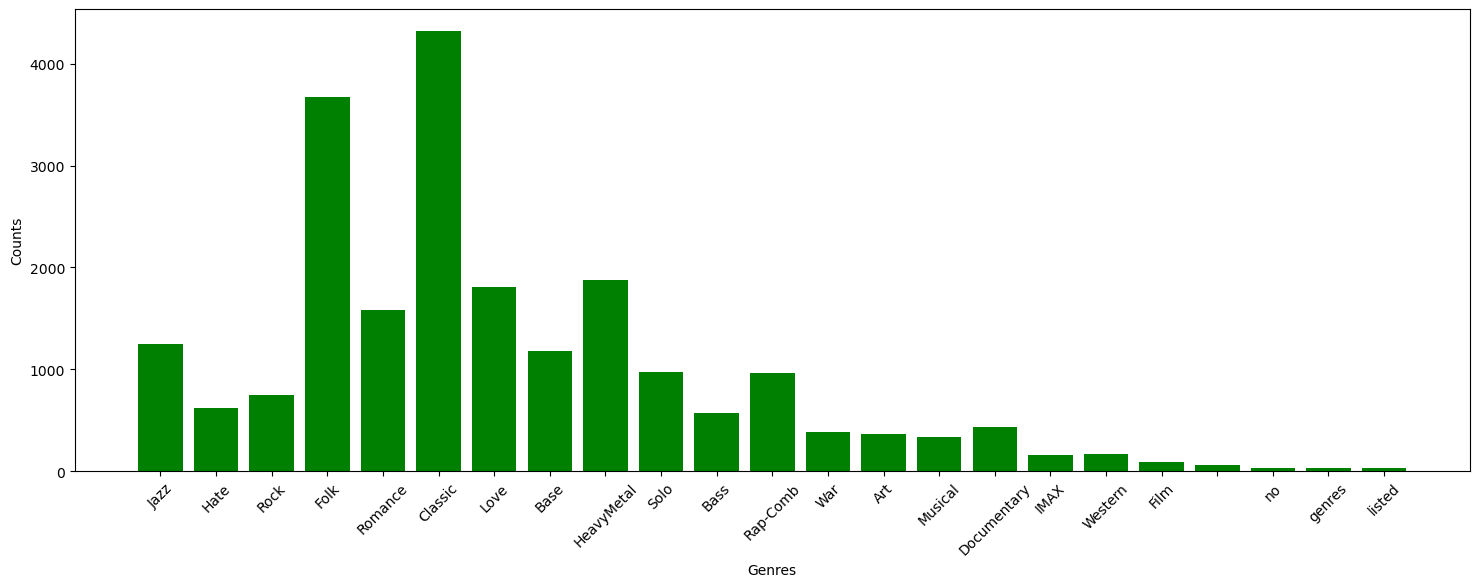

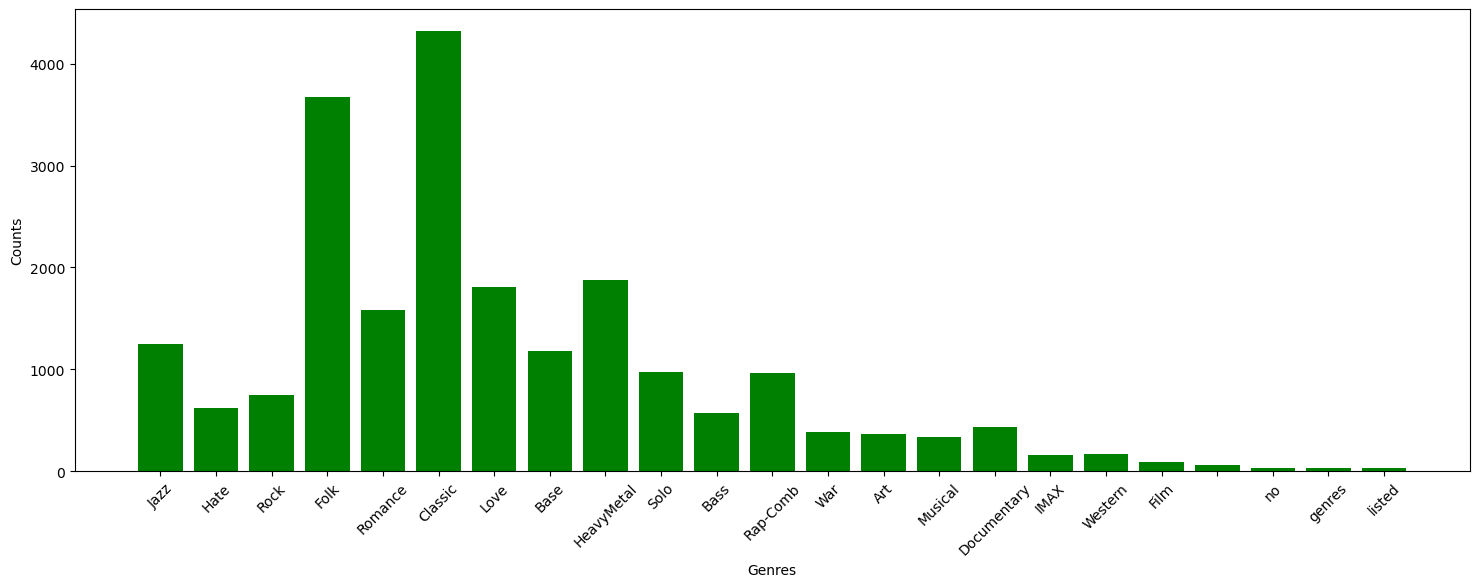

In [19]:
plt.figure(figsize=(18,6))
plt.bar(list(counts.keys()),counts.values(),color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.show()

# Term Frequency and Inverse Document Frequency (tf-idf)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
songs['genres']=songs['genres'].str.replace('Rap-Comb','Rap')

In [39]:
tfidf_vector=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf_vector.fit_transform(songs['genres'])

In [40]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'art'), (1, 'base'), (2, 'bass'), (3, 'classic'), (4, 'documentary'), (5, 'film'), (6, 'folk'), (7, 'genres'), (8, 'hate'), (9, 'heavymetal'), (10, 'imax'), (11, 'jazz'), (12, 'listed'), (13, 'love'), (14, 'musical'), (15, 'rap'), (16, 'rock'), (17, 'romance'), (18, 'solo'), (19, 'war'), (20, 'western')]


In [41]:
print(tfidf_matrix[:5])

  (0, 11)	1.0
  (1, 16)	0.5940761164298742
  (1, 8)	0.6233790368007639
  (1, 11)	0.5084015581850143
  (2, 17)	0.819170276063785
  (2, 6)	0.5735503977974231
  (3, 3)	0.46583696216345366
  (3, 17)	0.724859668658722
  (3, 6)	0.5075178671084329
  (4, 6)	1.0


In [42]:
tfidf_matrix.shape

(9643, 21)

In [43]:
tfidf_matrix.todense()[0]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])

In [44]:
from sklearn.metrics.pairwise import linear_kernel

In [45]:
sim_matrix=linear_kernel(tfidf_matrix,tfidf_matrix)

In [46]:
sim_matrix

array([[1.        , 0.50840156, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50840156, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.5735504 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.5735504 , ..., 0.        , 0.        ,
        1.        ]])

# Make the Recommendation Engine

In [47]:
# the function to convert from index to title_year
def get_title_year_from_index(index):
    return songs[songs.index == index]['title'].values[0]

# the function to convert from title to index
def get_index_from_title(title):

    return songs[songs.title == title].index.values[0]

# Did You Mean

In [48]:
from fuzzywuzzy import fuzz

In [49]:
def matching_score(a,b):
    return fuzz.ratio(a,b)

In [50]:
# a function to convert index to title
def get_title_from_index(index):

    return songs[songs.index == index]['title'].values[0]

In [51]:
# the function to return the most similar title to the words a user types
def find_closest_title(title):
    leven_scores = list(enumerate(songs['title'].apply(matching_score, b=title)))
    sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
    closest_title = get_title_from_index(sorted_leven_scores[0][0])
    distance_score = sorted_leven_scores[0][1]
    return closest_title, distance_score

# Recommend Songs

In [52]:
def contents_based_recommender(songs_likes, how_many):
    closest_title, distance_score = find_closest_title(songs_likes)
    if distance_score == 100:
        songs_index = get_index_from_title(closest_title)
        songs_list = list(enumerate(sim_matrix[int(songs_index)]))
        similar_songs = list(filter(lambda x:x[0] != int(songs_index), sorted(songs_list,key=lambda x:x[1], reverse=True))) # remove the typed movie itself

        print('Here\'s the list of songs similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    for i,s in similar_songs[:how_many]: 
        print(get_title_year_from_index(i))

In [53]:
contents_based_recommender('Soul',20)

Here's the list of songs similar to Soul.

Crying Time
My Life Would Suck Without You
Sajana  Ft Faheem Mazhar 
El Cara Bonita
Lunes Por La Madrugada
Get Your Hustle On
The Loco Motion
Viaje Al Averno
Dementia
Boat Day At the Marina
I See War
Cry On  Acoustic Demo 
I've Been Lonely  For So Long 
Get Together   Album Version
Cutting Edge
Still
Can't Help Falling In Love
Livin' Above Your Head
Voyagers   Improvisation 12
Vine Pa'echar Candela
